In [2]:
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import nltk as nltk
#import pyarrow
import bz2
import json
import datetime
from iteration_utilities import deepflatten
import nltk as nltk
import scipy.stats as stats
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asbjo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [49]:
#path_to_file = '/content/drive/MyDrive/Quotebank/'

'''
path_to_file = ['quotes-2015.json-001.bz2','quotes-2016.json-002.bz2','quotes-2017.json.bz2',
                  'quotes-2018-004.json.bz2','quotes-2019-005.json.bz2','quotes-2020.json.bz2']

files_with_sentiment = ['clean-quotes-2015_with_sentiment.csv.bz2','clean-quotes-2016_with_sentiment.csv.bz2','clean-quotes-2017_with_sentiment.csv.bz2',
                  'clean-quotes-2018_with_sentiment.csv.bz2','clean-quotes-2019_with_sentiment.csv.bz2','clean-quotes-2020_with_sentiment.csv.bz2']
'''
path_to_file = ['quotes-2018.json-004.bz2','quotes-2019.json-005.bz2','quotes-2020.json.bz2']

files_with_sentiment = ['clean-quotes-2018_with_sentiment.csv.bz2','clean-quotes-2019_with_sentiment.csv.bz2','clean-quotes-2020_with_sentiment.csv.bz2']

path_to_wikidata_file = '/content/drive/MyDrive/Project datasets/speaker_attributes.parquet'

wikidata_csv = '/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2' 

In [3]:
def weekday_number(date):
  ''' Returning the weekday number of a date, e.g., 0 for Mondays.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday number.

  Returns
  -------
  weekday_number: int
    The weekday number of the date.
  '''

  weekday_number = date.weekday()
  return weekday_number


def weekday(date):
  ''' Returning the name of the weekday for a date.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday.

  Returns
  -------
  weekday: str
    The weekday of the date.
  '''
  
  day_number = date.weekday()
  week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  weekday = week_days[day_number]
  return weekday


def week(date):
  ''' Returning the week number of a date.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday.

  Returns
  -------
  week_number: int
    The week number of the date.
  '''

  week_number = date.week()
  return week_number


def month(date):
  ''' Returning the month name of date.

  Parameters
  ----------
  date: datetime
    A date for which to find the month name.

  Returns
  -------
  name_month: str
    The name of the month.
  '''
  name_month = date.month_name()
  return name_month


def add_time(chunk):
  ''' Adding columns for weekday, weekday number and month name to a chunk.

  Parameters
  ----------
  chunk: dataframe
    The chunk for which to add date information.

  Returns
  -------
  chunk: dataframe
    The chunk with date information.
  '''

  chunk['weekday'] = chunk['date'].apply(lambda x: weekday(x))
  chunk['weekday_number'] = chunk['date'].apply(lambda x: weekday_number(x))  
  chunk['Month'] =  chunk['date'].apply(lambda x: month(x))
  chunk['date_short'] = pd.to_datetime(chunk['date']).dt.date
  return chunk


In [4]:
def add_dict(key, dictionary):
  ''' Incrementing the value of a key in a dictionary.
  
  Parameters
  ----------
  key: object
    The key for which to increment the value.
  
  dictionary: dict
    A dictionary in which we are incrementing the value of the key, or adding the key if not already present.

  Returns
  -------
  dictionary: dict
    The given dictionary after incrementing the value.
  '''
  
  if key in dictionary:
    dictionary[key] += 1
  else:
    dictionary[key] = 1
  return dictionary


def to_dict(dictionary, chunk_column):
  ''' Making a column of a dataframe into a dictionary, e.g., making a dictionary where weekdays are keys,
  and the values are the number of occurences of the key in the key.
  
  Parameters
  ----------
  dictionary: dict
    An initalized dictionary, either containing some preset keys or empty.
  
  chunk_column: series
    A series containing a column of a dataframe.

  Returns
  -------
  dictionary: dict
    A dictionary containing the desired values and keys as descripted.
  '''

  chunk_column.apply(lambda x: add_dict(x, dictionary))
  return dictionary

In [5]:
def find_media(url, medias_list):
  ''' Returning the media outlet where the quote is found, 
  but only if the outlet is present in medias_list.
  
  Parameters
  ----------
  url: array
    An entry in the column 'urls' of the Quotebank dataset, where the first value is the first source where the quote was found.
  
  medias_list: array
    An array containing some chosen media outlets, e.g., 'nytimes'.
  
  Returns
  -------
  media: str
    The first entry in url if its present in medias_list.
  '''

  for string in medias_list:
    url_string = str(url[0])
    if string in url_string:
      media = string
      return media


def get_media(chunk, medias_list):
  ''' Adding column with the media outlet where the quote is first found, 
  but only if the outlet is present in medias_list.
  
  Parameters
  ----------
  chunk: dataframe  
    A chunk of the Quotebank dataset.

  medias_list: array
    An array containing some chosen media outlets represented as strings, e.g., 'nytimes'.

  Returns
  -------
  chunk: dataframe
    The given chunk of the dataset, now containing a column 'media_outlet' 
    keeping the media where the quote was first found.
  '''

  chunk['media_outlet'] = chunk['urls'].apply(lambda x: find_media(x, medias_list))
  return chunk

In [6]:
def occurences_stats(chunk):
  ''' Returning the median and 75-th percentile of 'numOccurences' for the given chunk, as well as the chunk size.
  
  Parameters
  ----------
  chunk: dataframe
    The dataframe keeping a chunk of the dataset.
  
  Returns
  -------
  chunk_stats: array
    An array keeping the median, 75-th percentile.
  '''
  
  median = chunk.numOccurrences.describe()['50%']
  third_quartile = chunk.numOccurrences.describe()['75%']
  chunk_stats = [median, third_quartile]
  return chunk_stats


def stats_entire_dataset(occurence_stats_list):
  ''' Aggregating and printing statistics on numOccurences for the entire data set based upon the values in occurence_stats_list.
  
  Parameters
  ----------
  occurence_stats_list: array
    A 2D-array containing median and 75th percentile for each chunk of the dataset.   
  '''

  avg_median = 0
  avg_75th = 0
  for element in occurence_stats_list:
    avg_median += element[0]
    avg_75th += element[1]
  avg_median = avg_median/len(occurence_stats_list)
  avg_75th = avg_75th/len(occurence_stats_list)

  print(f'Average of median for each chunk for numOccurences: {round(avg_median, 2)}')
  print(f'Average 75th quantile for each chunk for  numOccurences: {round(avg_75th, 2)}')


def add_length(chunk):
  ''' Helper function adding the length of each quote in a new column.
  
  Parameters
  ----------
  chunk: dataframe
    A chunk of the dataset.
    
  Returns
  -------
  chunk: dataframe
    The given chunk now containing a 'len_quote' column.
  '''

  chunk['len_quote'] = chunk['quotation'].apply(lambda x: len(str(x)))
  return chunk

In [ ]:
# Initializing an array that will store the mean and variance of 'numOccurences' as well as the size of a chunk
occurence_stats_list = []

# Initializing dictionaries for dates, weekdays and months that will store values for all the chunks
date_dictionary = {}

# Dictionaries for weekdays and months are initialized with keys to keep them in the correct order for later plotting
weekday_dictionary = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0,
                      'Friday': 0, 'Saturday': 0, 'Sunday': 0}

month_dictionary = {'January': 0, 'February': 0,'March': 0,
                    'April': 0, 'May': 0, 'June': 0, 
                    'July': 0, 'August': 0, 'September': 0,
                    'October': 0, 'November': 0, 'December': 0}

# Iterating through all the cleaned data sets in chunks
for x in range(len(files_pre_cleaning)): 
  print('Working on %d. dataset'%(x+1))
  df_reader = pd.read_json(path_to_file + files_pre_cleaning[x], lines=True, compression='bz2', chunksize=50000)
  for chunk in df_reader:
    chunk = add_time(chunk)
    
    # Inserting values in the dictionaries
    date_dictionary = to_dict(date_dictionary, chunk['date_short'])
    weekday_dictionary = to_dict(weekday_dictionary, chunk['weekday'])
    month_dictionary = to_dict(month_dictionary, chunk['Month'])

    # Generating descriptive stats for the chunk and adding them to occurence_stats_list
    occurence_stats_list.append(occurences_stats(chunk))

# Creating empty array to store dictionary values
arr = []
for element in date_dictionary.values():
    arr.append(element)
arr = np.array(arr)

# Calculating mean, std, and median for date_dictionary
mean = np.mean(arr)
std = np.std(arr)
median = np.median(arr)

In [21]:
#Bruker ikke per nå
#from empath import Empath
#lexicon = Empath()


In [7]:
from textblob import TextBlob

In [8]:
media_outlets = ['nytimes', 'wsj', 'womansday', 'nbcnews', 'foxnews', 'aarp', 'usmagazine', 'espn', 'usatoday', 
'newstoday', 'sportingnews', 'theguardian', 'people', 'tmz', 'mtv', 'cnn', 'msn', 'reuters', 'timesrepublican', 
'nationalgeographic', 'latimes', 'washingtonpost', 'startribune', 'chicagotribune', 'usnews', 'theathletic', 
'rollingstone', 'vanityfair', 'intouchweekly', 'starmagazine', 'bbc', 'independent', 'thesun', 'thetimes',
'express', 'dailymail', 'mirror', 'economist', ]

'''
chunk = get_media(chunk, media_outlets)
for element in media_outlets:
    media_chunk = chunk.loc[chunk['media_outlet'] == element]
    #print("Number of quotes in %s: %d"%(element, media_chunk.shape[0]))

'''


'\nchunk = get_media(chunk, media_outlets)\nfor element in media_outlets:\n    media_chunk = chunk.loc[chunk[\'media_outlet\'] == element]\n    #print("Number of quotes in %s: %d"%(element, media_chunk.shape[0]))\n\n'

In [50]:
# Initializing a sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()



for x in range(len(path_to_file)):
# Reading the data in chunks
  df_reader = pd.read_json(path_to_file[x], lines=True, compression='bz2', chunksize=500000)
  for chunk in df_reader:


    #Dropping unnecesary columns
    chunk = chunk.drop(axis=1, columns = 'quoteID')
    chunk = chunk.drop(axis=1, columns = 'phase')
    chunk = chunk.drop(axis=1, columns = 'speaker')
    chunk = chunk.drop(axis=1, columns = 'qids')
    chunk = chunk.drop(axis=1, columns = 'numOccurrences')
    chunk = chunk.drop(axis=1, columns = 'probas')

    chunk = get_media(chunk, media_outlets)
    # Dropping NaN values in media_outlet
    chunk = chunk.dropna(axis=0, subset=['media_outlet'])
    chunk = chunk.drop(axis=1, columns = 'urls')

    # Calculating compound sentiment scores for the chunk and append the values in a column
    chunk['compound'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
    chunk['positive'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
    chunk['negative'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
    chunk['blob_polar'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment.polarity)
    chunk['blob_subj'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    chunk = chunk.drop(axis=1, columns = 'quotation')

    #Adding date_short
    chunk['date_short'] = pd.to_datetime(chunk['date']).dt.date
    chunk = chunk.drop(axis=1, columns = 'date')
    
    chunk.to_csv(path_or_buf= files_with_sentiment[x], compression='bz2', mode = 'a')
    print('chunk OK')

  

chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK


In [4]:
df_reader = pd.read_csv('media_outlet_with_sentiment/clean-quotes-2015_with_sentiment.csv.bz2', compression='bz2', index_col=[0])

C:\Users\asbjo\anaconda3\envs\ADA\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df_reader.head()

,media_outlet,compound,positive,negative,blob_polar,blob_subj,date_short
22.0,washingtonpost,0.25,0.083,0.0,0.0,0.0,2015-12-13
34.0,startribune,0.0,0.0,0.0,0.0625,0.35416666666666663,2015-10-02
52.0,mtv,0.0,0.0,0.0,-0.08333333333333333,0.21666666666666667,2015-10-09
53.0,express,-0.34,0.073,0.094,0.6,1.0,2015-11-17
59.0,reuters,-0.2732,0.0,0.11,-0.1875,0.5,2015-02-06


In [14]:
df_reader.describe()

,compound,positive,negative,blob_polar,blob_subj
count,52906.000000,52906.000000,52906.000000,52906.000000,52906.000000
mean,0.152175,0.124269,0.067706,0.109480,0.384565
std,0.458667,0.142090,0.114094,0.270425,0.299372
min,-0.988600,0.000000,0.000000,-1.000000,0.000000
25%,-0.025800,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.090000,0.000000,0.000000,0.400000
75%,0.525600,0.208000,0.106000,0.250000,0.595833
max,0.995200,1.000000,1.000000,1.000000,1.000000


In [6]:
df_reader['compound'] = df_reader['compound'].apply(lambda x: float(x))
df_reader['positive'] = df_reader['positive'].apply(lambda x: float(x))
df_reader['negative'] = df_reader['negative'].apply(lambda x: float(x))
df_reader['blob_polar'] = df_reader['blob_polar'].apply(lambda x: float(x))
df_reader['blob_subj'] = df_reader['blob_subj'].apply(lambda x: float(x))


ValueError: could not convert string to float: 'compound'

In [39]:
# Looking at the differences in the sentiment across media outlets
espn = df_reader.loc[df_reader['media_outlet']=='espn']

print("Sentiment scores for quotes in ESPN:")
print(espn['compound'].describe())

Sentiment scores for quotes in ESPN:
count    4273.000000
mean        0.264721
std         0.446538
min        -0.938500
25%         0.000000
50%         0.297500
75%         0.642800
max         0.992800
Name: compound, dtype: float64


In [40]:
# Looking at the differences in the sentiment across media outlets
nytimes = df_reader.loc[df_reader['media_outlet']=='nytimes']

print("Sentiment scores for quotes in New York Times:")
print(nytimes['compound'].describe())

Sentiment scores for quotes in New York Times:
count    85.000000
mean      0.119058
std       0.375447
min      -0.913600
25%      -0.033300
50%       0.000000
75%       0.421500
max       0.895700
Name: compound, dtype: float64


In [41]:
usmagazine = df_reader.loc[df_reader['media_outlet']=='usmagazine']

print("Sentiment scores for quotes in USmagazine:")
print(usmagazine['compound'].describe())

Sentiment scores for quotes in USmagazine:
count    337.000000
mean       0.226207
std        0.467449
min       -0.944000
25%        0.000000
50%        0.177900
75%        0.636900
max        0.958700
Name: compound, dtype: float64


In [42]:
wsj = df_reader.loc[df_reader['media_outlet']=='wsj']

print("Sentiment scores for quotes in the Wall Street Journal:")
print(wsj['compound'].describe())

Sentiment scores for quotes in the Wall Street Journal:
count    1361.000000
mean        0.138739
std         0.418898
min        -0.953100
25%         0.000000
50%         0.000000
75%         0.458800
max         0.972600
Name: compound, dtype: float64


In [43]:
womansday = df_reader.loc[df_reader['media_outlet']=='womansday']

print("Sentiment scores for quotes in the Womansday:")
print(womansday['compound'].describe())

Sentiment scores for quotes in the Womansday:
count    21.000000
mean      0.183405
std       0.493311
min      -0.680800
25%      -0.059800
50%       0.000000
75%       0.700300
max       0.930000
Name: compound, dtype: float64


In [44]:
fox = df_reader.loc[df_reader['media_outlet']=='foxnews']

print("Sentiment scores for quotes in FOX news:")
print(fox['compound'].describe())

Sentiment scores for quotes in FOX news:
count    1210.000000
mean        0.071698
std         0.467825
min        -0.956500
25%        -0.256300
50%         0.000000
75%         0.421500
max         0.987800
Name: compound, dtype: float64


In [47]:
t, p = stats.ttest_ind(nytimes['compound'], fox['compound'], equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in Wall Street Journal:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in Wall Street Journal:
t-value: 1.1043000630464117, p-value: 0.2720301991970484


In [25]:
nytimes = df_reader.loc[df_reader['media_outlet']=='nytimes']
print("Sentiment scores for quotes in New York Times:")
print(nytimes['compound'].describe())


Sentiment scores for quotes in New York Times:
count    85.000000
mean      0.119058
std       0.375447
min      -0.913600
25%      -0.033300
50%       0.000000
75%       0.421500
max       0.895700
Name: compound, dtype: float64


In [26]:
nytimes['blob_polar']

2941      0.000000
4597      0.000000
5322     -0.900000
10781     0.200000
12635     0.000000
            ...   
479179    0.395833
481119    0.350000
482527    0.500000
483633    0.100000
492681    0.000000
Name: blob_polar, Length: 85, dtype: float64

In [27]:
nytimes['compound'] = nytimes['compound'].apply(lambda x: float(x))


nytimes['compound']

2941     -0.3612
4597      0.1531
5322     -0.6249
10781     0.0000
12635     0.3612
           ...  
479179    0.7845
481119    0.4215
482527    0.0000
483633    0.4754
492681    0.0000
Name: compound, Length: 85, dtype: float64

In [28]:
print(nytimes['blob_polar'].describe())

count    85.000000
mean      0.081249
std       0.313936
min      -0.900000
25%       0.000000
50%       0.000000
75%       0.250000
max       1.000000
Name: blob_polar, dtype: float64


(array([ 1.,  2.,  2.,  8., 38., 12., 13.,  5.,  1.,  3.]),
 array([-0.9 , -0.71, -0.52, -0.33, -0.14,  0.05,  0.24,  0.43,  0.62,
         0.81,  1.  ]),
 <BarContainer object of 10 artists>)

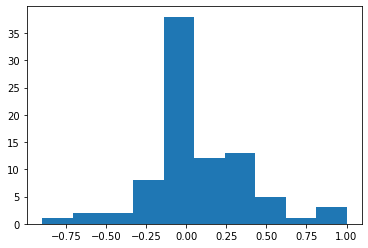

In [29]:
plt.hist(nytimes['blob_polar'])

(array([ 1.,  1.,  5.,  8.,  7., 32.,  3., 15.,  7.,  6.]),
 array([-0.9136 , -0.73267, -0.55174, -0.37081, -0.18988, -0.00895,
         0.17198,  0.35291,  0.53384,  0.71477,  0.8957 ]),
 <BarContainer object of 10 artists>)

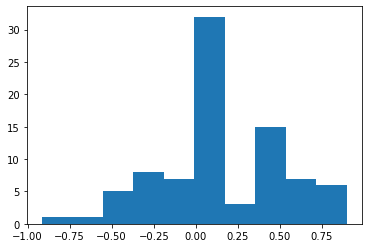

In [30]:
plt.hist(nytimes['compound'])

(array([  6.,  15.,  17.,  15., 105.,  12.,  34.,  33.,  46.,  54.]),
 array([-0.944  , -0.75373, -0.56346, -0.37319, -0.18292,  0.00735,
         0.19762,  0.38789,  0.57816,  0.76843,  0.9587 ]),
 <BarContainer object of 10 artists>)

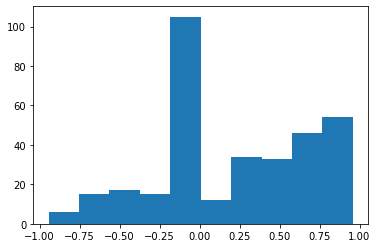

In [31]:
plt.hist(usmagazine['compound'])

In [32]:
nytimes

,media_outlet,compound,positive,negative,blob_polar,blob_subj,date_short
2941,nytimes,-0.3612,0.000,0.294,0.000000,0.000000,2015-12-14
4597,nytimes,0.1531,0.233,0.183,0.000000,0.000000,2015-10-02
5322,nytimes,-0.6249,0.165,0.615,-0.900000,0.700000,2015-01-29
10781,nytimes,0.0000,0.000,0.000,0.200000,0.400000,2015-11-30
12635,nytimes,0.3612,0.455,0.000,0.000000,0.000000,2015-07-31
...,...,...,...,...,...,...,...
479179,nytimes,0.7845,0.173,0.000,0.395833,0.545833,2015-03-24
481119,nytimes,0.4215,0.412,0.000,0.350000,0.650000,2015-07-14
482527,nytimes,0.0000,0.000,0.000,0.500000,0.500000,2015-07-31
483633,nytimes,0.4754,0.177,0.000,0.100000,0.100000,2015-07-24


In [37]:
date = nytimes.groupby('date_short').compound.mean()


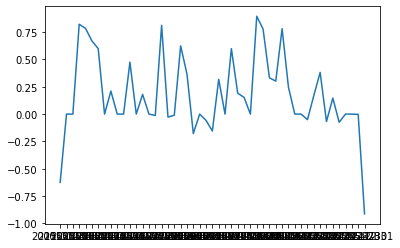

In [38]:
plt.plot(date)